In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
df = pd.read_csv('finalData.csv')

In [ ]:
df.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations,avgTemp
0,"Chicago,United States",2012-05-01,17.9,11.0,14.6,17.9,11.0,14.6,11.2,80.3,...,6,NaN,2012-05-01T05:46:04,2012-05-01T19:49:44,0.35,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"72534014819,KORD,KMDW,72530094846,74466504838,...",14.45
1,"Chicago,United States",2012-05-02,25.9,14.7,21.0,25.9,14.7,21.0,15.3,71.9,...,6,NaN,2012-05-02T05:44:46,2012-05-02T19:50:49,0.38,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72534014819,KORD,KMDW,72530094846,74466504838,...",20.30
2,"Chicago,United States",2012-05-03,29.3,20.4,24.8,30.2,20.4,25.2,18.0,66.8,...,5,NaN,2012-05-03T05:43:28,2012-05-03T19:51:54,0.42,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,"72534014819,KORD,KMDW,72530094846,74466504838,...",24.85
3,"Chicago,United States",2012-05-04,22.7,11.9,17.3,22.7,11.9,17.3,13.6,79.0,...,5,NaN,2012-05-04T05:42:13,2012-05-04T19:52:59,0.45,"Rain, Overcast",Cloudy skies throughout the day with rain clea...,rain,"72534014819,KORD,KMDW,72530094846,74466504838,...",17.30
4,"Chicago,United States",2012-05-05,15.7,12.4,13.8,15.7,12.4,13.8,11.4,85.9,...,8,NaN,2012-05-05T05:40:58,2012-05-05T19:54:04,0.50,Overcast,Cloudy skies throughout the day.,cloudy,"72534014819,KORD,KMDW,72530094846,74466504838,...",14.05


In [ ]:
df.shape

(4018, 34)

In [ ]:
df.isnull().sum()

name                   0
datetime               0
tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
precipcover            0
preciptype          2194
snow                   0
snowdepth              0
windgust             625
windspeed              0
winddir                0
sealevelpressure       0
cloudcover             0
visibility             0
solarradiation         0
solarenergy            0
uvindex                0
severerisk          3541
sunrise                0
sunset                 0
moonphase              0
conditions             0
description            0
icon                   0
stations               0
avgTemp                0
dtype: int64

We are performing the prediction/forecasting on 'close' column 


In [ ]:
df1 = df.reset_index()['temp']

In [ ]:
df1


0       14.6
1       21.0
2       24.8
3       17.3
4       13.8
        ... 
4013    10.8
4014    12.0
4015    10.1
4016     6.6
4017     6.7
Name: temp, Length: 4018, dtype: float64

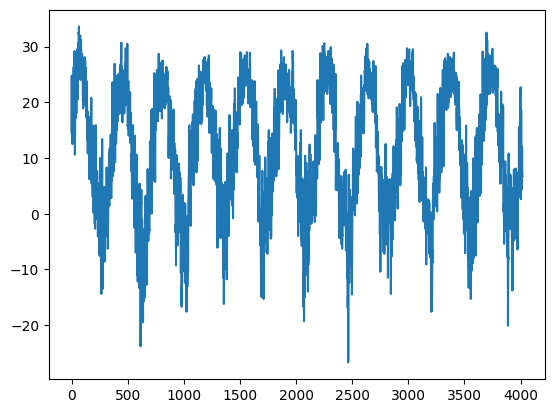

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt
plt.plot(df1)

In [ ]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
df1.shape

(4018, 1)

In [ ]:
##splitting dataset into train and test split
train_size = int(len(df1)*0.65)
train_data,test_data = df1[0:train_size,:],df1[train_size:len(df1),:1]

In [ ]:
train_size

2611

In [ ]:
#Data Preprocessing
# convert an array of values into a dataset matrix

def create_ds(dataset,time_steps):   #Time Steps is how many previous records considered to predict the current record
    data_x,data_y = [],[]
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps),0]
        data_x.append(a)
        b = dataset[i+time_steps,0]
        data_y.append(b)
    return np.array(data_x),np.array(data_y)

In [ ]:
time_step = 1000
X_train, y_train = create_ds(train_data, time_step)
X_test, ytest = create_ds(test_data, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(1610, 1000)
(1610,)


(None, None)

In [ ]:
print(X_test.shape), print(ytest.shape)

(406, 1000)
(406,)


(None, None)

In [ ]:
#Before feeding into lstm we must convert dataset into 3d 
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
#Model Creation 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1000,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1000, 50)          10400     
                                                                 
 lstm_4 (LSTM)               (None, 1000, 50)          20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
26/26 [==============================] - 49s 2s/step - loss: 0.0667 - val_loss: 0.0166
Epoch 2/10
26/26 [==============================] - 43s 2s/step - loss: 0.0117 - val_loss: 0.0099
Epoch 3/10
26/26 [==============================] - 42s 2s/step - loss: 0.0090 - val_loss: 0.0091
Epoch 4/10
26/26 [==============================] - 43s 2s/step - loss: 0.0082 - val_loss: 0.0088
Epoch 5/10
26/26 [==============================] - 43s 2s/step - loss: 0.0081 - val_loss: 0.0088
Epoch 6/10
26/26 [==============================] - 42s 2s/step - loss: 0.0080 - val_loss: 0.0087
Epoch 7/10
26/26 [==============================] - 43s 2s/step - loss: 0.0080 - val_loss: 0.0086
Epoch 8/10
26/26 [==============================] - 42s 2s/step - loss: 0.0078 - val_loss: 0.0087
Epoch 9/10
26/26 [==============================] - 42s 2s/step - loss: 0.0079 - val_loss: 0.0085
Epoch 10/10
26/26 [==============================] - 43s 2s/step - loss: 0.0081 - val_loss: 0.0084


In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

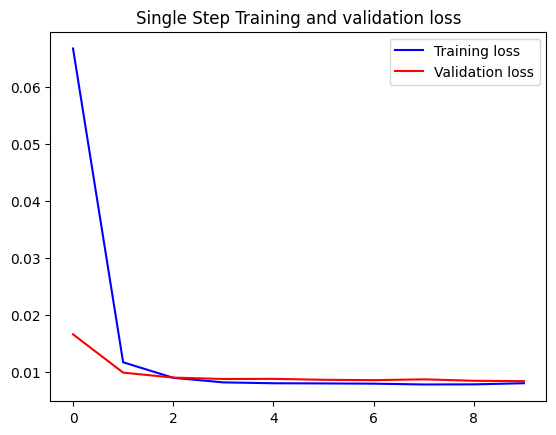

In [ ]:
plot_train_history(history,
                   'Single Step Training and validation loss')

In [ ]:
train_predict1=model.predict(X_train)
test_predict1=model.predict(X_test)

13/13 [==============================] - 4s 300ms/step


In [ ]:
# We have scaled it, so we need to reverse scale it to find the o/p
train_predict=scaler.inverse_transform(train_predict1)
test_predict=scaler.inverse_transform(test_predict1)

In [ ]:
#rmse
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.08725984727667775

In [ ]:
ytesting = scaler.inverse_transform(ytest.reshape(-1,1))
math.sqrt(mean_squared_error(ytesting,test_predict))

5.535831369951432

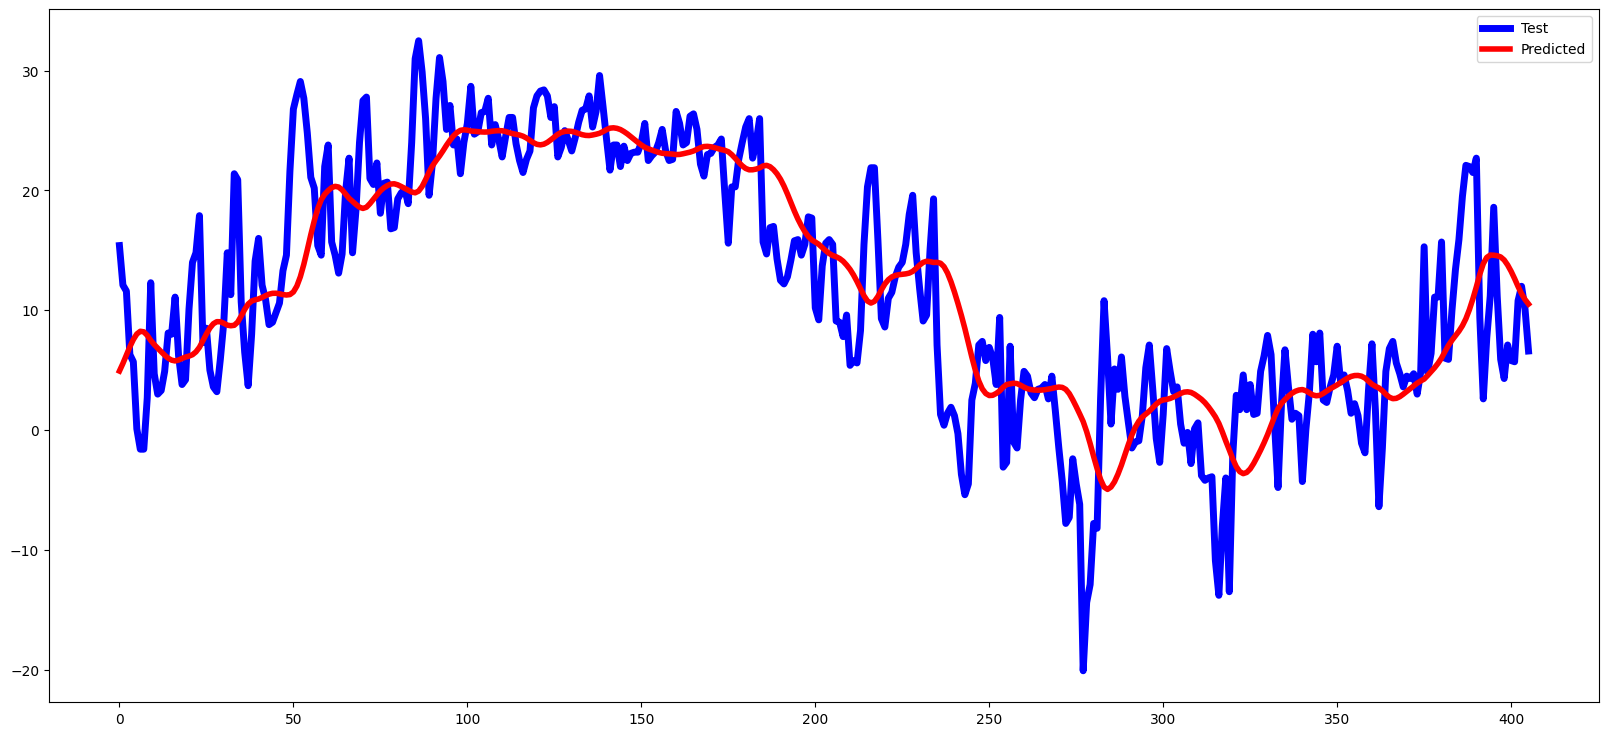

In [ ]:
ytesting = scaler.inverse_transform(ytest.reshape(-1,1))
plt.figure(figsize=(20,9))
plt.plot(ytesting , 'blue', linewidth=5)
plt.plot(test_predict,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.show()

In [ ]:
features_considered = ['humidity', 'temp', 'dew']

In [ ]:
features = df[features_considered]
features.index = df['datetime']
features.head()

,humidity,temp,dew
datetime,,,
2012-05-01,80.3,14.6,11.2
2012-05-02,71.9,21.0,15.3
2012-05-03,66.8,24.8,18.0
2012-05-04,79.0,17.3,13.6
2012-05-05,85.9,13.8,11.4


array([<Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>], dtype=object)

<Figure size 1700x1700 with 0 Axes>

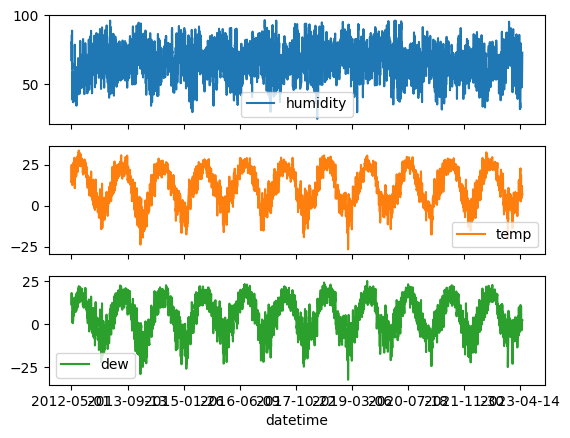

In [ ]:
plt.figure(figsize=(17,17))
features.plot(subplots=True)

In [ ]:
#predicting future 30 days
#For predicting next day after last test data, we need to take previous 100 values(timestep)
x_input=test_data[1307:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
x_input

array([[0.43946932, 0.39635158, 0.44444444, 0.45273632, 0.37976783,
        0.37313433, 0.37645108, 0.37810945, 0.26202322, 0.21393035,
        0.31011609, 0.37645108, 0.21890547, 0.4079602 , 0.49087894,
        0.47097844, 0.51907131, 0.47097844, 0.50580431, 0.46434494,
        0.46600332, 0.52404643, 0.54560531, 0.57379768, 0.54726368,
        0.45107794, 0.36318408, 0.47927032, 0.55389718, 0.50248756,
        0.45771144, 0.46600332, 0.46268657, 0.37147595, 0.44278607,
        0.49419569, 0.57545605, 0.53731343, 0.57711443, 0.48424544,
        0.48092869, 0.50248756, 0.51907131, 0.55887231, 0.50912106,
        0.51907131, 0.49751244, 0.46600332, 0.47927032, 0.46268657,
        0.42454395, 0.41127695, 0.49751244, 0.56218905, 0.46932007,
        0.33665008, 0.41791045, 0.52404643, 0.55555556, 0.5655058 ,
        0.53565506, 0.52072968, 0.50248756, 0.51741294, 0.51409619,
        0.52072968, 0.49253731, 0.52238806, 0.69651741, 0.52238806,
        0.54892206, 0.62686567, 0.62686567, 0.70

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
#temp_input

In [ ]:
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<15):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

[0.58353174]
101
1 day input [0.39635158 0.44444444 0.45273632 0.37976783 0.37313433 0.37645108
 0.37810945 0.26202322 0.21393035 0.31011609 0.37645108 0.21890547
 0.4079602  0.49087894 0.47097844 0.51907131 0.47097844 0.50580431
 0.46434494 0.46600332 0.52404643 0.54560531 0.57379768 0.54726368
 0.45107794 0.36318408 0.47927032 0.55389718 0.50248756 0.45771144
 0.46600332 0.46268657 0.37147595 0.44278607 0.49419569 0.57545605
 0.53731343 0.57711443 0.48424544 0.48092869 0.50248756 0.51907131
 0.55887231 0.50912106 0.51907131 0.49751244 0.46600332 0.47927032
 0.46268657 0.42454395 0.41127695 0.49751244 0.56218905 0.46932007
 0.33665008 0.41791045 0.52404643 0.55555556 0.5655058  0.53565506
 0.52072968 0.50248756 0.51741294 0.51409619 0.52072968 0.49253731
 0.52238806 0.69651741 0.52238806 0.54892206 0.62686567 0.62686567
 0.70315091 0.54228856 0.54063018 0.60862355 0.66500829 0.70646766
 0.76616915 0.8092869  0.80762852 0.79933665 0.81923715 0.5986733
 0.48590381 0.57048093 0.62852405 

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,116)

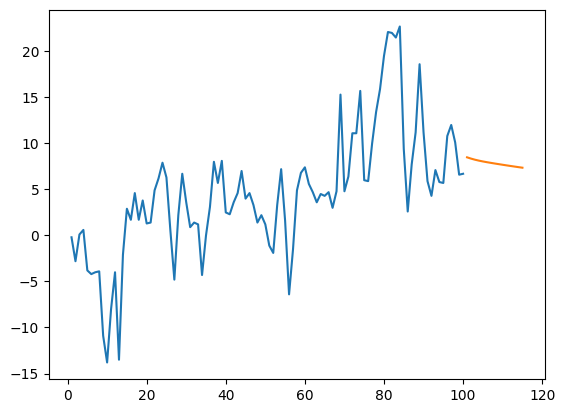

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[3918:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

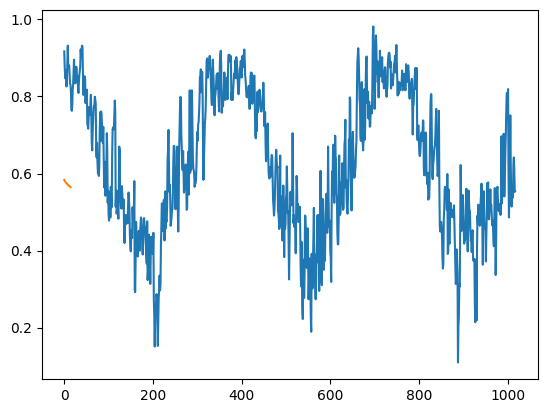

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[3000:4018])
plt.plot(lst_output)

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

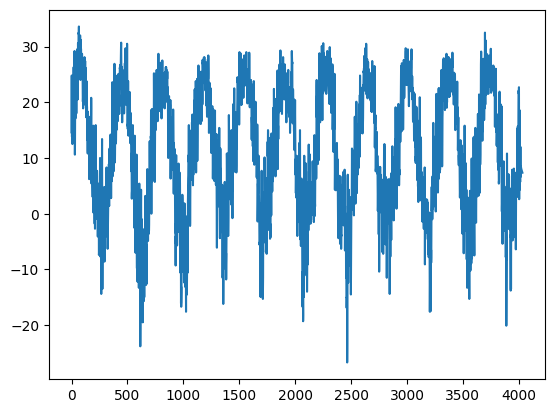

In [ ]:
plt.plot(df3)